In [115]:
import pickle
import torch
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd
import numpy as np
import adabmDCA
from adabmDCA.utils import get_device, get_dtype, get_mask_save

import sys
sys.path.append('..')
import indep_sites

In [403]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]
ns = range(len(experiment_ids))
ts = torch.arange(len(round_ids))
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [5]:
def load_frequences(experiment_id, pseudocount):
    pc_str = format(pseudocount, '.2f')
        
    filename = experiment_id + "freq_pseudocount" + pc_str + ".pkl"
    filepath = "saved/freq_pseudocount/" + filename
    
    with open(filepath, 'rb') as f:
        fi, fij, total_reads = pickle.load(f)

    return fi, total_reads

In [394]:
pseudocount = 0.00

fi_all, total_reads_all = zip(*[load_frequences(id, pseudocount) for id in experiment_ids])

In [404]:
lr = 0.01
max_epochs = 10**4

params_all = []
history_all = []

for n in range(len(experiment_ids)):
    params=indep_sites.init_parameters(fi_all[n])
    params, history = indep_sites.train(
        fi=fi_all[n],
        total_reads=total_reads_all[n], 
        params=params,
        lr=lr,
        max_epochs=max_epochs,
        target_error=1e-6,
        progress_bar=False)
    
    params_all.append(params)
    history_all.append(history)

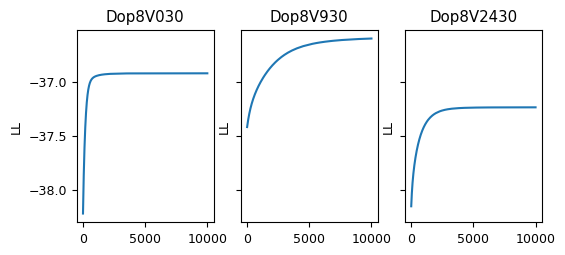

In [405]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(6,2.5))
for n in range(len(experiment_ids)):
    ax = axes[n]
    ax.plot(history_all[n]["log-likelihood"])
    ax.set_title(f"{experiment_ids[n]}")
    ax.set_ylabel("LL")

# Compare across datasets

In [110]:
sequences_all = [[selex_dca.sequences_from_file(experiment_id, round_id, device) 
                  for round_id in round_ids] for experiment_id in experiment_ids];

In [ ]:
sequences_unique_all, inverse_indices_all, counts_all = zip(*[zip(*[
    torch.unique(seq_t, dim=0, return_inverse=True, return_counts=True)
    for seq_t in sequences_all[n]]) for n in ns])

In [116]:
sequences_unique_oh_all = [[adabmDCA.functional.one_hot(s) for s in sequences_unique_all[n]] for n in ns]

In [117]:
filepath = './saved/wildtypes_sites.pkl'
with open(filepath, 'rb') as f:
    wts = pickle.load(f)

wts_oh = [adabmDCA.functional.one_hot(wts[n][None,:]) for n in ns]

### log ps

In [390]:
params_ps_all = [indep_sites.get_params_ps(params_all[n]) for n in ns]

In [406]:
logps_cross = [[[-indep_sites.compute_energy(
    sequences_unique_oh_all[m][t], params_ps_all[n]) 
              for t in ts] for n in ns] for m in ns]

In [392]:
logps_wt_cross = [[-indep_sites.compute_energy(wts_oh[m], params_ps_all[n]) 
                    for n in ns] for m in ns]

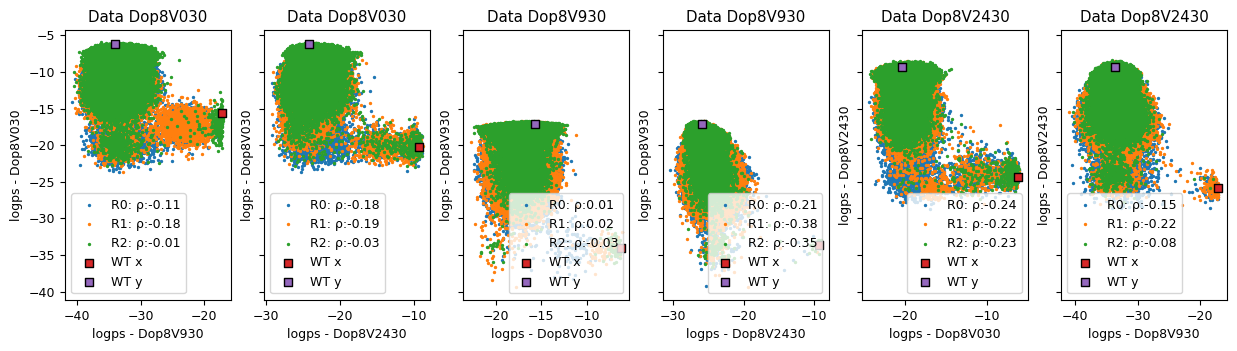

In [407]:
N = 10**5

fig, axes = plt.subplots(1, 6, figsize=(15,3.5), sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=9) 

j = -1
for m in ns:
    for n in ns:
        if m != n:
            j += 1
            ax = axes[j]
            for t in ts:
                x = logps_cross[m][n][t]
                y = logps_cross[m][m][t]
                pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
                idx = random.sample(range(len(x)),min(N, len(x)))
                ax.scatter(x[idx], y[idx], label=f"R{t}: ρ:{pearson:.{2}f}", s=2, color=colors[t])
                ax.set_xlabel(f"logps - {experiment_ids[n]}")
                ax.set_ylabel(f"logps - {experiment_ids[m]}")
                ax.set_title(f"Data {experiment_ids[m]}")
            ax.scatter(logps_wt_cross[n][n], logps_wt_cross[n][m], marker='s',
                       edgecolor='black', label="WT x", color=colors[3])
            ax.scatter(logps_wt_cross[m][n], logps_wt_cross[m][m], marker='s',
                       edgecolor='black', label="WT y", color=colors[4])
            ax.legend()
# plt.tight_layout()
plt.savefig('img/logps_cross_indep_sites.png')

## logNst

In [408]:
params_Nst_all = [[indep_sites.get_params_at_round(params_all[n], t) for t in ts] for n in ns]

In [409]:
logNst_cross = [[[-indep_sites.compute_energy(
    sequences_unique_oh_all[m][t], params_Nst_all[n][t]) 
              for t in ts] for n in ns] for m in ns]

In [410]:
logNst_wt_cross = [[[-indep_sites.compute_energy(wts_oh[m], params_Nst_all[n][t]) 
                     for t in ts] for n in ns] for m in ns]

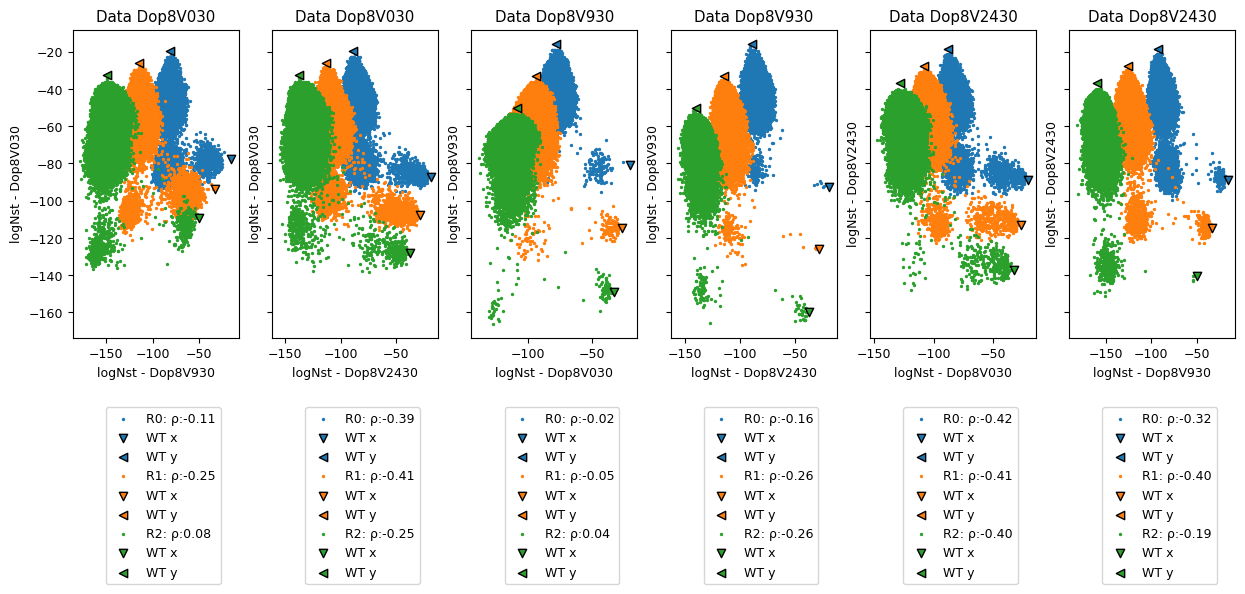

In [424]:
N = 10**5

fig, axes = plt.subplots(1, 6, figsize=(15,4), sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=9) 

j = -1
for m in ns:
    for n in ns:
        if m != n:
            j += 1
            ax = axes[j]
            for t in ts:
                x = logNst_cross[m][n][t]
                y = logNst_cross[m][m][t]
                pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
                idx = random.sample(range(len(x)),min(N, len(x)))
                ax.scatter(x[idx], y[idx], label=f"R{t}: ρ:{pearson:.{2}f}", s=2, color=colors[t])
                ax.set_xlabel(f"logNst - {experiment_ids[n]}")
                ax.set_ylabel(f"logNst - {experiment_ids[m]}")
                ax.set_title(f"Data {experiment_ids[m]}")
            # ax.scatter(logps_wt_cross[n][n], logps_wt_cross[n][m], marker='s',
            #            edgecolor='black', label="WT x", color=colors[3])
            # ax.scatter(logps_wt_cross[m][n], logps_wt_cross[m][m], marker='s',
            #            edgecolor='black', label="WT y", color=colors[4])
                ax.scatter(logNst_wt_cross[n][n][t], logNst_wt_cross[n][m][t], marker='v',
                       edgecolor='black', label="WT x", color=colors[t])
                ax.scatter(logNst_wt_cross[m][n][t], logNst_wt_cross[m][m][t], marker='<',
                       edgecolor='black', label="WT y", color=colors[t])
            ax.legend(loc=(0.2,-0.8))
# plt.tight_layout()
plt.savefig('img/logNst_cross_indep_sites.png')